Import and Look at the data

In [1]:
%matplotlib inline
from scripts.functions import *
from astropy.timeseries import LombScargle
sns.set()
plot_kwgs = {'markersize': 0.5, 'alpha': 0.3}

Text(0.5, 0, 'Time (sec)')

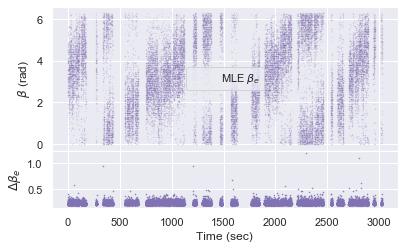

In [2]:
t_e = ct.T_E
mean_e, var_e = episode_wise_analysis()
sigma_e = var_e**0.5
fig = plt.figure(0)
frame1 = fig.add_axes((.1, .3, .8, .5))
plt.plot(t_e, mean_e, '.m', label='MLE $\\beta_e$', **plot_kwgs)

plt.ylabel('$\\beta$ (rad)')
plt.legend()
frame1.set_xticklabels([])  # Remove x-tic labels for the first frame

frame2 = fig.add_axes((.1, .1, .8, .2))
plt.plot(t_e, var_e ** 0.5, '.m', markersize=1, label='MLE $\\beta_e$')

plt.ylabel('$\\Delta \\beta_e$')
plt.xlabel('Time (sec)')

Observe by eyes that $\beta_t\approx \beta_0+\beta_1 t\approx 4 + \frac{2 \pi}{1500}t$.
We will use Fourier analysis to find $\beta_0, \beta_1$ more accurately.
Then we will refine the values more by using non linear fitting techniques. 

1) Define $z_t = e^{i\beta_t}$, then $z_t \approx e^{i(\beta_0+\beta_1 t)}$.
We will find $\hat{\beta_1}$ the secular frequency with the maximum amplitude.
We will find the phase, $\hat{\beta_0}$ afterwards.

We will limit ourselves by eyes to reasonable frequencies,
how many periods, at maximum, did the process have? 

In [3]:
max_periods = 5 # how many periods, at maximum, did the process have?
max_w = max_periods * 2 * pi / ct.T_END_SEASON[-1]
w_dom = np.linspace(0, max_w)

z = exp(1j*mean_e)
ft = naive_fourier_transform(t_e, z, w_dom)

Find the suspect: $\tilde\beta$

In [4]:
hat_ix = abs(ft).argmax()
beta_hat = beta0_hat, beta1_hat = np.angle(ft[hat_ix])%(2*pi), w_dom[hat_ix]

Find $\hat\beta \in argmin (- Re( z_t \cdot e^{i(\beta_0+\beta_1 t)})) $ 
by non-linear fmin function.

In [5]:
beta0, beta1 = fmin(lambda beta: -np.real(z@exp(-1j*(t_e*beta[1]+beta[0]))), beta_hat)
affine_hyp = beta0 + beta1*t_e

Optimization terminated successfully.
         Current function value: -13274.880920
         Iterations: 29
         Function evaluations: 55


Demode the data and look at our choice of linear fit.

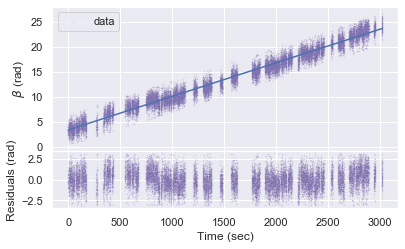

In [6]:
demoded = cheat_demode(t_e, mean_e, beta0, beta1)
affine_res = demoded-affine_hyp

plot_hyp_and_res(demoded, affine_hyp, **plot_kwgs)

In [7]:
del z, ft, mean_e

Find Spectral content using unequally spaced discrete fourier method  

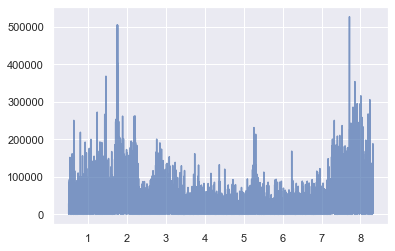

In [8]:
window_factor = 100
min_freq = .5
freq = np.linspace(min_freq, ct.FREQ_NYQUIST,
                   ct.N_E * window_factor, endpoint=True) # we do not care for such slow frequencies
ft = naive_fourier_transform(t_e, affine_res, freq, secular=False)

fig, ax = plt.subplots()
pgram = np.real_if_close(ft*ft.conj())
ax.plot(freq, pgram, alpha=.7)

find the 3 prominent peaks manually

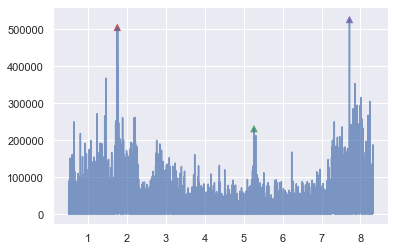

In [9]:
n_peaks = 3
mask = np.stack(((freq > 1.5) * (freq < 2),
                (freq > 5) * (freq < 5.5),
                (freq > 7.5) * (freq < 8)))
ixs = (pgram * mask).argmax(axis=-1)
freq_max = freq[ixs]
peak_heights = pgram[ixs]
ax.scatter(freq_max, peak_heights, c=('r','g','m') ,marker='^')
fig

Focus on the peak frequency between 1 and 2. In the residuals model $r(t)$,
Find the Amplitudes $A,B$ in $r(t) \approx A \cos (\omega_0 t) + B \sin (\omega_0 t)$
with linear regression.

previous residuals norm = 184.906
current residuals norm = 184.801


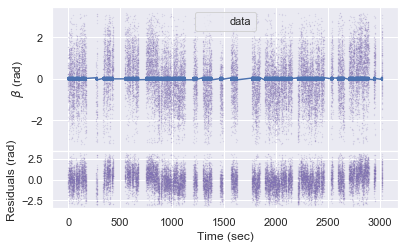

In [10]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

X_1 = np.c_[cos(2*pi*freq_max[0]*t_e), sin(2*pi*freq_max[0]*t_e)]

model.fit(X_1, affine_res)

sine_hyp = X_1@model.coef_

plot_hyp_and_res(affine_res, sine_hyp, **plot_kwgs)
print('previous residuals norm = {:.6g}\n'
      'current residuals norm = {:.6g}'.format(norm(affine_res), norm(affine_res-sine_hyp)))


Observe that sinusoid hypothesis does not help to reduce the error at all.

We want to see whether the seasonal process is constant but insignificant or
non-constant.

Look at the peak heights as a function of time

In [11]:
peak_heights  = np.zeros((n_peaks, ct.N_S))
fourier_tr = np.zeros(len(freq), dtype='complex128')

freq_max = np.zeros((n_peaks, ct.N_S))
reshaped_t = t_e.reshape((ct.N_S, ct.N_E))
reshaped_res = affine_res.reshape((ct.N_S, ct.N_E))
t = time()
for ix_s in range(ct.N_S):
    fourier_tr += naive_fourier_transform(reshaped_t[ix_s], reshaped_res[ix_s],
                                          freq, secular=False)
    pgram = np.real_if_close(fourier_tr.conj() * fourier_tr)
    ixs = (pgram * mask).argmax(axis=-1)
    freq_max[:, ix_s] = freq[ixs]
    peak_heights[:, ix_s] = pgram[ixs]
print('time elapsed: {:.3g} sec'.format(time() - t))

time elapsed: 42.5 sec


LogLog plot

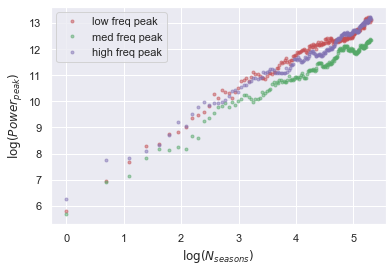

In [12]:
log_peaks = log(peak_heights)
log_seasons = log(np.arange(ct.N_S)+1)
plt.plot(log_seasons, log_peaks[0], '.r', alpha=.5, label='low freq peak')
plt.plot(log_seasons, log_peaks[1], '.g', alpha=.5, label='med freq peak')
plt.plot(log_seasons, log_peaks[2], '.m', alpha=.5, label='high freq peak')
plt.xlabel('$\log ( N_{seasons} )$')
plt.ylabel('$\log ( {Power}_{peak} )$')
plt.legend()

Indices plot

Text(0, 0.5, 'Peak Frequency $ \\frac{rad}{sec} $')

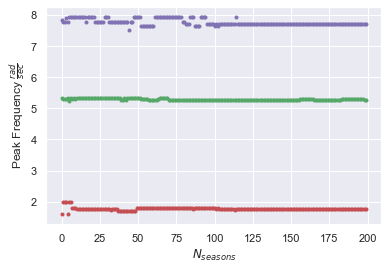

In [13]:
plt.plot(range(ct.N_S), freq_max[0], '.r')
plt.plot(range(ct.N_S), freq_max[1], '.g')
plt.plot(range(ct.N_S), freq_max[2], '.m')
plt.xlabel('$N_{seasons}$')
plt.ylabel('Peak Frequency $ \\frac{rad}{sec} $')

In the last figures, observe that the powers of the peak frequencies does
not grow square with the number observations (less than to the power of $\frac{13-6}{5} =1.4$). 




